### plotting tanh activation toy 1D example

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


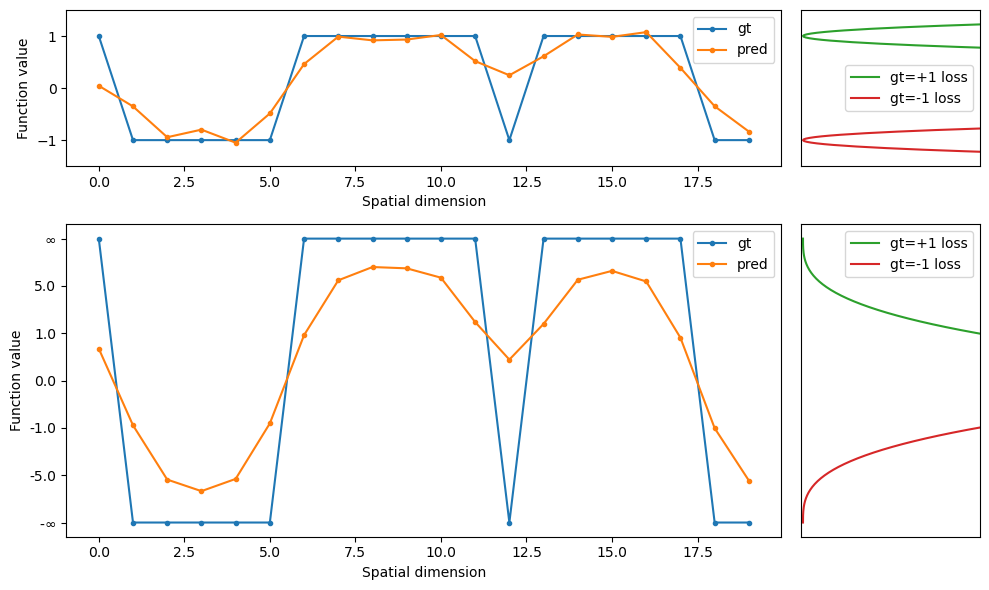

In [105]:
%load_ext autoreload
%autoreload 2
import os,sys
sys.path.append('./source/')
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as nd


gt = np.random.rand(20)
gt = nd.gaussian_filter1d(gt,1)
gt = ((gt>0.5)*2-1).astype(float)
pred = nd.gaussian_filter(gt,1)+np.random.randn(20)*0.1
gt2 = gt*10
pred2 = nd.gaussian_filter(gt2,1)*0.8+np.random.randn(20)*0.1
fig, ax = plt.subplots(2, 2, figsize=(10, 6), gridspec_kw={'width_ratios': [4, 1], 'height_ratios': [1, 2]})

t = np.linspace(-1.5,1.5,200)
t2 = np.linspace(-10,10,200)

gt_p1 = (t-1)**2*20
gt_m1 = (t+1)**2*20
gt2_p1 = np.abs(t2-10)**3/300
gt2_m1 = np.abs(t2+10)**3/300

for i in range(2):
    ax[i,0].plot([gt,gt2][i],".-",label="gt")
    ax[i,0].plot([pred,pred2][i],".-",label="pred")
    ax[i,0].set_xlabel("Spatial dimension")
    ax[i,0].set_ylabel("Function value")

    ax[i,0].legend()
    ax[i,1].set_xticks([])
    ax[i,1].set_yticks([])    


    ax[i,1].plot([gt_p1,gt2_p1][i],[t,t2][i],"-",color=f"C{2}",label="gt=+1 loss")
    ax[i,1].plot([gt_m1,gt2_m1][i],[t,t2][i],"-",color=f"C{3}",label="gt=-1 loss")
    ax[i,1].legend()
    ax[i,1].set_xlim(-0.01,1)
    yy = [1.5,11][i]
    ax[i,0].set_ylim(-yy,yy)
    ax[i,1].set_ylim(-yy,yy)
y_tick_pos = np.linspace(-10,10,7)
y_tick_labels =["-$\infty$"]+ [-5.0,-1.0,0.0,1.0,5.0]+["$\infty$"]
plt.sca(ax[1,0])
_=plt.yticks(y_tick_pos,y_tick_labels)
plt.tight_layout()

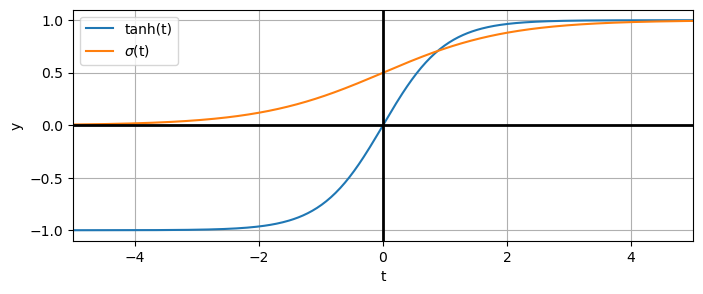

In [115]:
#plot tanh(t) and sigmoid(t) from -5 to 5
plt.figure(figsize=(8, 3))
t = np.linspace(-5,5,400)
y = np.tanh(t)
y2 = 1/(1+np.exp(-t))
plt.plot(t,y,"-",label="tanh(t)")
plt.plot(t,y2,"-",label="$\sigma$(t)")
plt.grid()
plt.xlabel("t")
plt.ylabel("y")
plt.xlim(-5,5)
plt.axhline(linewidth=2, color='k')
plt.axvline(linewidth=2, color='k')
plt.legend()

In [ ]:
def always_return_1():
    return 1
def always_return_0():
    return 0
    

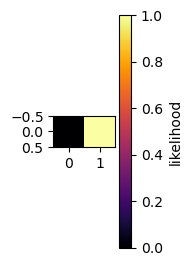

In [112]:
#make inferno colorbar
plt.figure(figsize=(1,4))
plt.imshow([[0,1]],cmap="inferno")
plt.colorbar(label="likelihood")

### Cleanup functions

In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('./source/')
from utils import nuke_saves_folder
from argparse_utils import kill_missing_ids

#help(kill_missing_ids)
#help(nuke_saves_folder)

In [9]:
dry = True
kill_missing_ids(name_key="sample_opts",dry=dry)
kill_missing_ids(name_key="args",dry=dry)

Keeping 33 ids out of 33 in sample_opts.


In [13]:
nuke_saves_folder(dry_run=False)

The following folders will be removed:
saves/ver-0.0.0/2024-02-13-09-55-19-585338_nc2[lr]
Removing saves/ver-0.0.0/2024-02-13-09-55-19-585338_nc2[lr]


### collect gen_table data

In [33]:
%load_ext autoreload
%autoreload 2
import os,sys
sys.path.append('./source/')
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from argparse_utils import TieredParser, get_ckpt_name,load_existing_args
from source.plot_utils import collect_gen_table
from utils import save_dict_list_to_json,wildcard_match
from pathlib import Path
import re



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:


def collect_gen_table(gen_id_patterns="gw_sweep_*",
                   model_id_patterns="*",
                   save=False,
                   return_table=True,
                   save_name="",
                   verbose=True,
                   sort_by_save_path=True,
                   make_pretty_table=True,
                   pretty_digit_limit=5,
                   search_gen_setups_instead=False,
                   include_mode="last"):
    assert include_mode in ["last","last_per_gen_id","all"], f"expected include_mode to be one of ['last','last_per_gen_id','all'], found {include_mode}"
    if isinstance(gen_id_patterns,str):
        gen_id_patterns = [gen_id_patterns]
    if isinstance(model_id_patterns,str):
        model_id_patterns = [model_id_patterns]
    model_id_dict = TieredParser().load_and_format_id_dict()
    
    save_paths = []
    table = pd.DataFrame()
    for model_id,v in model_id_dict.items():
        matched = False
        for model_id_pattern in model_id_patterns:
            if wildcard_match(model_id_pattern,model_id):
                matched = True
                break
        if matched:
            fn = Path(v["save_path"])/"logging_gen.csv"
            if fn.exists():
                with open(str(fn),"r") as f:
                    column_names = f.readline()[:-1].split(",")
                data = np.genfromtxt(str(fn), dtype=str, delimiter=",")[1:]
                if data.size==0:
                    continue
                if "gen_id" not in column_names:
                    continue
                if search_gen_setups_instead:
                    file_gen_ids = data[:,column_names.index("setup_name")].astype(str)
                else:
                    file_gen_ids = data[:,column_names.index("gen_id")].astype(str)
                match_idx = set()

                for idx,fgi in enumerate(file_gen_ids):
                    for gen_id_pattern in gen_id_patterns:
                        if wildcard_match(gen_id_pattern,fgi):
                            match_idx.add(idx)
                            break
                if len(match_idx)==0:
                    continue
                if include_mode=="last":
                    match_idx = [max(match_idx)]
                    if verbose and len(match_idx)>1:
                        print(f"Warning: multiple matches found for model_id {model_id} and gen_ids {data[match_idx,column_names.index('gen_id')]}")
                elif include_mode=="last_per_gen_id":
                    len_before = len(match_idx)
                    match_idx = list(match_idx)
                    match_idx = [max([i for i in match_idx if file_gen_ids[i]==file_gen_ids[j]]) for j in match_idx]
                    if verbose and len(match_idx)<len_before:
                        print(f"Warning: multiple matches found for model_id {model_id} and gen_ids {data[match_idx,column_names.index('gen_id')]}")
                else:
                    match_idx = list(match_idx)
                match_data_s = data[match_idx]
                table = pd.concat([table,pd.DataFrame(match_data_s,columns=column_names)],axis=0)
                save_paths.extend([v["save_path"] for _ in range(len(match_idx))])
    if table.shape[0]==0:
        if return_table:
            return table
        else:
            return
    table["save_path"] = save_paths
    if sort_by_save_path:
        table = table.sort_values(by=["save_path"])
    table = table.loc[:, (table != "").any(axis=0)]
    table_pd = table.copy()
    table = {k: table[k].tolist() for k in table.keys()}
    if make_pretty_table:
        buffer = 2
        pretty_table = ["" for _ in range(len(table["save_path"])+2)] 
        for k in table.keys():
            pretty_col = ["" for _ in range(len(table["save_path"])+2)]
            
            if table[k][0].replace(".","").isdigit() and table[k][0].find(".")>=0:
                idx = slice(pretty_digit_limit+2)
            else:
                idx = slice(None)
            max_length = max(max([len(str(x)[idx]) for x in table[k]]),len(k))+buffer
            pretty_col[0] = k+" "*(max_length-len(k))
            pretty_col[1] = "#"*max_length
            pretty_col[2:] = [str(x)[idx]+" "*(max_length-len(str(x)[idx])-2)+", " for x in table[k]]
            if k=="model_name":
                pretty_col[0] = "model_name"+" "*(max_length-len("model_name")-1)+"# "
                pretty_col[1] = "#"*(max_length+1)
                pretty_col[2:] = [s.replace(","," #") for s in pretty_col[2:]]
                pretty_table = [pretty_col[i]+pretty_table[i] for i in range(len(pretty_table))]
            else:
                pretty_table = [pretty_table[i]+pretty_col[i] for i in range(len(pretty_table))]
        table["pretty_table"] = pretty_table
    if save:
        save_dict_list_to_json(table,save_name,append=True)
    if return_table:
        return table_pd

table = collect_gen_table(model_id_patterns="sam[64",include_mode="all")
table

,ari,gen_id,gen_setup,hiou,iou,max_ari,max_hiou,mi,step,save_path
0,0.08546995807881244,gw_sweep_0,gw_sweep,0.04201299429793007,0.0007204451638843982,0.08546995807881244,0.04201299429793007,0.18687843408461405,100000,saves/ver-1.0.0/2024-02-22-17-44_sam[64_native...
1,0.6393827562938397,gw_sweep_1,gw_sweep,0.15654332347969174,0.001798824499007684,0.6393827562938397,0.15654332347969174,0.6498147561861398,100000,saves/ver-1.0.0/2024-02-22-17-44_sam[64_native...
2,0.6668579952888827,gw_sweep_2,gw_sweep,0.15466394625343807,0.0020510991609712257,0.6668579952888827,0.15466394625343807,0.6667084704597167,100000,saves/ver-1.0.0/2024-02-22-17-44_sam[64_native...
3,0.6969186681615543,gw_sweep_3,gw_sweep,0.13923884072413917,0.0019387904217324514,0.6969186681615543,0.13923884072413917,0.6796675034870705,100000,saves/ver-1.0.0/2024-02-22-17-44_sam[64_native...
4,0.735149173928091,gw_sweep_4,gw_sweep,0.11396911996331567,0.0024757513583639162,0.735149173928091,0.11396911996331567,0.6951301673215654,100000,saves/ver-1.0.0/2024-02-22-17-44_sam[64_native...
5,0.7396794518906913,gw_sweep_5,gw_sweep,0.09447390005928721,0.0019411756056701868,0.7396794518906913,0.09447390005928721,0.6793390057029413,100000,saves/ver-1.0.0/2024-02-22-17-44_sam[64_native...
6,0.7274255438394538,gw_sweep_6,gw_sweep,0.08787571529252704,0.0017463082054561107,0.7274255438394538,0.08787571529252704,0.6614292696297609,100000,saves/ver-1.0.0/2024-02-22-17-44_sam[64_native...
7,0.6802219664138779,gw_sweep_7,gw_sweep,0.07122642063342702,0.0017928640351255317,0.6802219664138779,0.07122642063342702,0.590612662974588,100000,saves/ver-1.0.0/2024-02-22-17-44_sam[64_native...


In [45]:
import numpy as np
ari_array = table["ari"].astype(float).to_numpy()
table["ari"].astype(float)

0    0.085470
1    0.639383
2    0.666858
3    0.696919
4    0.735149
5    0.739679
6    0.727426
7    0.680222
Name: ari, dtype: float64

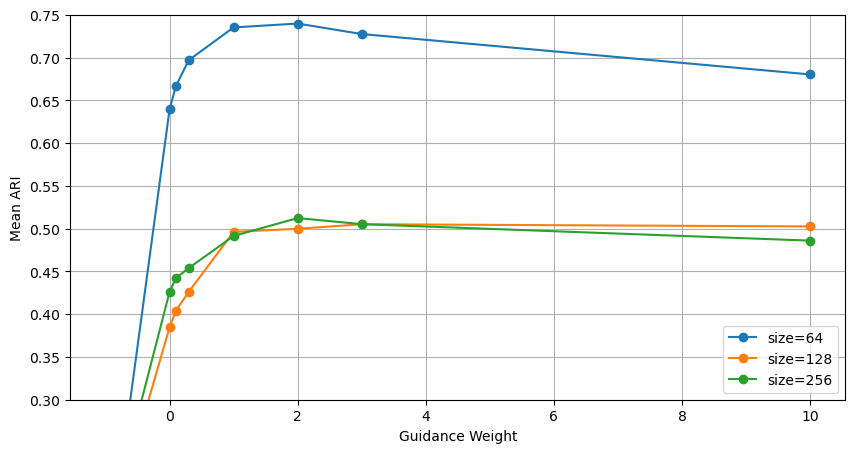

In [51]:
plt.figure(figsize=(10, 5))
gw = "-1.0;0.0;0.1;0.3;1.0;2.0;3.0;10.0".split(";")
gw  = [float(x) for x in gw]
for size in ["64","128","256"]:
    table = collect_gen_table(model_id_patterns="sam["+size,include_mode="all")
    plt.plot(gw,table["ari"].astype(float).to_numpy(),"o-",label=f"size={size}")
plt.xlabel("Guidance Weight")
plt.ylabel("Mean ARI")
plt.ylim(0.3,0.75)
plt.grid()
plt.legend()

### bla